# Importing Modules and Data

In [1]:
from learntools import Network, Learning
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
#https://www.ajbell.co.uk/market-research/sub/FUND:BJS8SJ3/charts-performance

# Defining the Broker and Relevant Functions

In [2]:
class broker:
    def __init__(self,data,dates,tradingBot,interest_rate=0.01):
        self.cash = 0 
        self.indexSum = 1 # starts with all money in index
        self.dateIndex = 0 
        self.dates = dates
        self.data = data / data[-1] # index is normalised to 1.0 start
        self.maxDate = len(data)
        self.tradingBot = tradingBot
        self.interest_rate = interest_rate
        self.daily_interest_rate = interest_rate / 365

        self.totalValue = np.zeros(len(data))
        self.indexValue = np.zeros(len(data))
        self.cashValue = np.zeros(len(data))
        
        
        if len(data) != len(dates):
            print('Error: data length does not match date length')
            
    def buy(self,value: float):
        if value > self.cash:
            value = self.cash
            #print('Warning Buy Cash greater than amount held. DateIndex/Date=',self.dateIndex,self.dates[self.dateIndex])
        
        self.cash = self.cash - value
        self.indexSum = self.indexSum + value/self.data[self.dateIndex]
        
        
    def sell(self,value: float):
        if value > self.indexSum:
            value = self.indexSum
            #print('Warning Sell Value greater than amount held. DateIndex/Date=',self.dateIndex,self.dates[self.dateIndex])
        
        self.indexSum = self.indexSum - value
        self.cash = self.cash + value*self.data[self.dateIndex]
            
    def makeMove(self):
        # assuming we make the trade after close
        # we will have seen the close price.
        # we will be testing is the close price is over/under valued
        # we thus need to add +1 to the index due to python indexing. 
        # e.g day 1 (index=0) needs just todays price which is
        # data[:index+1] = int 
        seenData = self.data[:self.dateIndex+1] #if dateIndex is 0 it is first day
        seenDates = self.dates[:self.dateIndex+1]

        # function here input: seen data 
        # returns a number between 0 and 1
        # 1 being all portfolio in cash
        # 0 being all portfolio in stock
        action = self.tradingBot(seenData,seenDates) # add function here
        
        if action == -1: #pass
            pass
        else:
            currentValue = self.cash + self.indexSum * self.data[self.dateIndex] # current value of portfolio
            wantedValue = action * currentValue # wanted value in cash

            if self.cash > wantedValue: #if we have more cash than wanted
                #buy
                cashValue = self.cash-wantedValue
                self.buy(cashValue)

            elif self.cash < wantedValue: #if we have less cash than wanted
                #sell
                cashValue = wantedValue - self.cash
                indexValue = cashValue/self.data[self.dateIndex]
                self.sell(indexValue)

        self.indexValue[self.dateIndex] = self.indexSum
        self.cashValue[self.dateIndex] = self.cash #+ self.cash * self.daily_interest_rate # add interest
        self.totalValue[self.dateIndex] = self.cash + self.indexSum * self.data[self.dateIndex]
        self.dateIndex += 1 # after move is made, move to next date
        
    def run(self):
        while self.dateIndex < self.maxDate:
            self.makeMove()


            
    def plot(self,dataName: str):
        ax = plt.gca()
        plotDF = pd.DataFrame()
        plotDF['Dates'] = self.dates
        plotDF['Index'] = self.data
        plotDF['Trader'] = self.totalValue
        
        plotDF.plot(x='Dates',y='Trader',ax=ax)
        plotDF.plot(x='Dates',y='Index',ax=ax,label=dataName)
        plt.xticks(rotation=90)
        '''
        plt.plot(self.dates,self.data,label = dataName)
        plt.plot(self.dates,self.totalValue,label = 'Trader')
        
        plt.title(dataName+' vs Trader Performance')
        plt.legend()
        '''

    def lossFunc(net):
        pass

        
def testData(n):
    x = np.arange(1,n+1)
    y = np.sin(30*np.pi*x/n) + 5
    return x,y

def getData(ticker,df):
    DF = df.drop(df[df['Ticker']!=ticker].index)
    Data = np.asarray(DF['Open'],dtype=float)
    Dates = np.asarray(DF['Date'])
    return Data,Dates

def linearMemoryDiff(seenData,seenDates,memory=0):
    '''
    function to fit a linear regression to 
    memory number of datapoints back
    then take the difference of the 
    predicted vs actual value
    '''
    if memory == 0:
        return 0
    else:
        seenData = seenData[-memory:]
        seenDates = seenDates[-memory:]
    
    x = np.arange(0, len(seenData))
    y = seenData
    
    coeffs = np.polyfit(x, y, 1)
    fit = np.poly1d(coeffs)
    
    predictedValue = fit(x[-1])

    return seenData[-1]/predictedValue - 1



# Preprocessing Data

In [3]:
# creating Input Data from varing linear regression sizes
def preprocess(data,int_dates):

    memory_lengths = [10,20,50,200,len(data)] # most popular moving average 
    
    input_matrix = np.zeros((len(data),len(memory_lengths)))
    print(input_matrix.shape)
    
    for i in range(len(data)-1):
        i = i + 1
        seenData = data[:i]
        seenDates = int_dates[:i]
        for j in range(len(memory_lengths)):
            if i == 1:
                pass
            else:
                input_matrix[i][j] = linearMemoryDiff(seenData,seenDates,memory_lengths[j])

    return input_matrix


# Import Data

In [4]:
DF = pd.read_csv('SPX.MAX.csv')
DF['Date'] = pd.to_datetime(DF['Date'])
data = DF['Close'].to_numpy()[-5000:]
int_dates = np.arange(0,len(data))

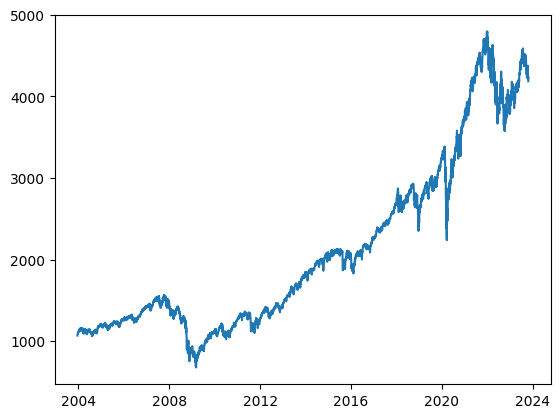

In [5]:
plt.plot(DF['Date'][-5000:],DF['Close'][-5000:])

In [6]:
input_matrix = preprocess(data,int_dates)

def loss_func(net):
    bot = lambda seenData,seenDates: net.forward([input_matrix[len(seenData)-1]])[0][0]
    env = broker(data,int_dates,bot)
    env.dateIndex = 200
    env.run()
    return 1/env.totalValue[-1]

(5000, 5)


In [12]:
net1 = Network.network(5,1)
net1.add_layer(Network.layer_dense(5,1))
net1.add_layer(Network.sigmoid())

loss,_ = Learning.random_learning(net1,loss_func,info=True)

Iter 0 Loss 1.7576968544837837
Iter 1 Loss 1.727851640014956
Iter 2 Loss 1.7194259208871343
Iter 3 Loss 1.69575377298354
Iter 4 Loss 1.6829555020342604
Iter 5 Loss 1.6727803521644284
Iter 6 Loss 1.6620198971525582
Iter 7 Loss 1.654990067352007
Iter 8 Loss 1.6470438608250784
Iter 9 Loss 1.6300961966502594
Iter 10 Loss 1.6160642305676387
Iter 11 Loss 1.6099861356683718
Iter 12 Loss 1.6031377807545582
Iter 13 Loss 1.5912301950688652
Iter 14 Loss 1.5830730449529298
Iter 15 Loss 1.568934784071031
Iter 16 Loss 1.5617637161113422
Iter 17 Loss 1.544347941382352
Iter 18 Loss 1.524311998114975
Iter 19 Loss 1.5113817405723755
Iter 20 Loss 1.50607081013164
Iter 21 Loss 1.4910904864777412
Iter 22 Loss 1.4541189648254806
Iter 23 Loss 1.4427835049060853
Iter 24 Loss 1.4207349562841074
Iter 25 Loss 1.4136475939975068
Iter 26 Loss 1.3998378180324356
Iter 27 Loss 1.3882428227788735
Iter 28 Loss 1.3866779088345582
Iter 29 Loss 1.3765112803845507
Iter 30 Loss 1.3727769551624793
Iter 31 Loss 1.365000549854

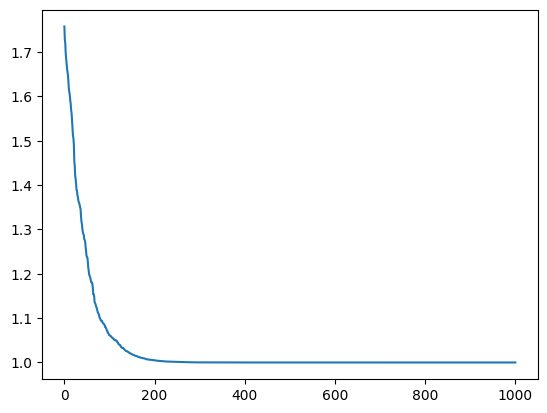

In [13]:
plt.plot(loss)

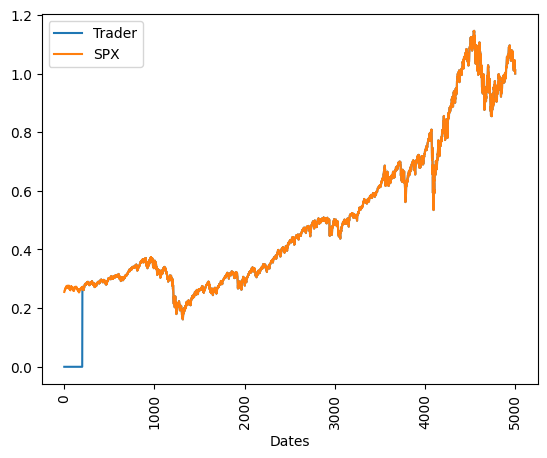

In [14]:
bot = lambda seenData,seenDates: net1.forward([input_matrix[len(seenData)-1]])[0][0]
env = broker(data,int_dates,bot)
env.dateIndex = 200
env.run()
env.plot('SPX')

In [ ]:
loss,_ = Learning.random_learning(net1,loss_func,info=True)

In [8]:
from learntools import VariableStructure

In [10]:
print('start')
var_net = VariableStructure.VariableStructure(5,1,loss_func,Network.sigmoid,info=True,threshold=0,max_its=10)

start
Epoch-0-loss-0.9684512739015766
Epoch-1-loss-0.9635087754106514
Epoch-2-loss-0.9602802071626094
Epoch-3-loss-0.9545599828998254
Epoch-4-loss-0.9487180442645563
Epoch-5-loss-0.9444501788686365
Epoch-6-loss-0.9382371870797237
Epoch-7-loss-0.9325469790303182
Epoch-8-loss-0.9272066241999403
Epoch-9-loss-0.9235682065757983
Epoch-10-loss-0.9189097623549728
Epoch-11-loss-0.9139797567632973
Epoch-12-loss-0.9095467233409227
Epoch-13-loss-0.9046474679675144
Epoch-14-loss-0.9004471194530925
Epoch-15-loss-0.8952322039220437
Epoch-16-loss-0.8916653528741717
Epoch-17-loss-0.887344236451291
Epoch-18-loss-0.8839573852048772
Epoch-19-loss-0.8815495831379042
Epoch-20-loss-0.8777682599857156
Epoch-21-loss-0.873679319330171
Epoch-22-loss-0.870462551762623
Epoch-23-loss-0.8681357409850026
Epoch-24-loss-0.8650408193356064
Epoch-25-loss-0.8633016874415629
Epoch-26-loss-0.8604525793009304
Epoch-27-loss-0.8567003238508557
Epoch-28-loss-0.8538745928976168
Epoch-29-loss-0.8526716612780512
Epoch-30-loss-0.8